# Projet SER

In [ ]:
!pip install numpy pandas scikit-learn
!pip install librosa
!pip install mrmr-selection
!pip install soundfile
!pip install librosa
!pip install kaggle

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
#from pymrmr import mRMR
import librosa
#from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
import soundfile as sf
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA

## Data Collection

### From local path

In [ ]:
"""
def collect_data_ravdess(audio_path):
    data = pd.DataFrame()

    for file in os.listdir(audio_path):
        if file.endswith(".wav"):
            filepath = os.path.join(audio_path, file)
            label = file.split("-")[2]  # Extracting emotion label from filename

            # Append the filepath and label to the DataFrame
            data = data.append({"filepath": filepath, "label": label}, ignore_index=True)

    return data

"""

### From kaggle

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"siakesophie","key":"760d5044c02669f464a1d97a873a4827"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# list datasets on kaggle with the name Ravdess
!kaggle datasets list -s RAVDESS

ref                                           title                                  size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------  ------------------------------------  -----  -------------------  -------------  ---------  ---------------  
uwrfkaggler/ravdess-emotional-speech-audio    RAVDESS Emotional speech audio        429MB  2019-01-19 18:28:31          37104        462  0.875            
uwrfkaggler/ravdess-emotional-song-audio      RAVDESS Emotional song audio          456MB  2019-01-19 21:01:49           1860         37  0.875            
kartik2khandelwal/speech-emotion-dataset      RAVDESS as .csv                       763KB  2021-09-15 13:12:51            658         17  0.5882353        
dmitrybabko/speech-emotion-recognition-en     Speech Emotion Recognition (en)       987MB  2021-01-25 12:59:50           8238         89  0.875            
uwrfkaggler/ravdess-facial-landmark-tracking  RAVDESS Facial Lan

In [5]:
# Authenticate into Kaggle and download the required dataset then unzip it in the folder in which we are found

import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('uwrfkaggler/ravdess-emotional-speech-audio', path='.', unzip=True)


## Data Processing
- Audio Normalization
- Silence Removal

In [6]:
def normalize(X):
    max_X = np.max(np.abs(X))
    Y = X / max_X

    return Y

In [7]:
def remove_silence(X, factor):
    max_X = np.max(np.abs(X))
    decision_threshold = max_X / factor

    # Find the indices of samples above the decision threshold
    indices_useful_X, _ = find_peaks(np.abs(X), height=decision_threshold)

    # Extract the useful samples
    Y = X[indices_useful_X[0]:indices_useful_X[-1] + 1]

    return Y


In [8]:
def normalise_remove_silence(input_filename, output_directory, factor):
    # Read the input audio file
    x, fs = librosa.load(input_filename, sr=None)

    # Normalize the audio
    y = normalize(x)

    # Remove silence
    z = remove_silence(y, factor)

    # Extract the filename and extension
    filename, extension = os.path.splitext(os.path.basename(input_filename))

    # Create the output filename in the specified directory
    output_filename = os.path.join(output_directory, f"{filename}_N_RS{factor}{extension}")

    # Write the processed audio to the output file
    sf.write(output_filename, z, fs)

## Audio Feature Extraction


In [9]:
from scipy.stats import mode

def global_feature_computation(feature_matrix, computations):
    computed_features = []
    for computation in computations:
        if computation == "mean":
            computed_features.append(np.mean(feature_matrix, axis=1))
        elif computation == "min":
            computed_features.append(np.min(feature_matrix, axis=1))
        elif computation == "max":
            computed_features.append(np.max(feature_matrix, axis=1))
        elif computation == "std":
            computed_features.append(np.std(feature_matrix, axis=1))
        elif computation == "range":
            computed_features.append(np.ptp(feature_matrix, axis=1))
        elif computation == "mode":
            # Use scipy.stats.mode to get mode and count
            mode_result = mode(feature_matrix, axis=1)
            computed_features.append(mode_result.mode.flatten())
        elif computation == "median":
            computed_features.append(np.median(feature_matrix, axis=1))
        elif computation == "1st_quartile":
            computed_features.append(np.percentile(feature_matrix, 25, axis=1))
        elif computation == "3rd_quartile":
            computed_features.append(np.percentile(feature_matrix, 75, axis=1))
        # Add conditions for other computations

    return np.concatenate(computed_features)

In [32]:
def extract_features(audio_path, features, global_computation):
    # Load the normalized and silence-removed audio
    audio, sr = librosa.load(audio_path)

    lst_spectral_flatness = []
    lst_spectral_centroid = []
    lst_mfcc = []
    lst_melspectrogram = []
    lst_chroma_stft = []
    lst_rms = []

    feature_list = []

    # Extract selected features
    for feature_name in features:
        if feature_name == "spectral_flatness":
            spectral_flatness = librosa.feature.spectral_flatness(y=audio)
            lst_spectral_flatness.append(global_feature_computation(spectral_flatness, global_computation))
        elif feature_name == "spectral_centroid":
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr = sr)
            lst_spectral_centroid.append(global_feature_computation(spectral_centroid, global_computation))
        elif feature_name == "mfcc":
            mfcc = librosa.feature.mfcc(y=audio, sr = sr)
            lst_mfcc.append(global_feature_computation(mfcc, global_computation))
        elif feature_name == "melspectrogram":
            mel_spectrum = librosa.feature.melspectrogram(y=audio, sr = sr)
            lst_melspectrogram.append(global_feature_computation(mel_spectrum, global_computation))
        elif feature_name == "chroma_stft":
            chroma_stft = librosa.feature.chroma_stft(y=audio, sr = sr)
            lst_chroma_stft.append(global_feature_computation(chroma_stft, global_computation))
        elif feature_name == "rms":
            rms = librosa.feature.rms(y=audio)
            lst_rms.append(global_feature_computation(rms, global_computation))


    feature_list.append(lst_spectral_flatness[0])
    feature_list.append(lst_spectral_centroid[0])
    feature_list.append(lst_mfcc[0])
    feature_list.append(lst_melspectrogram[0])
    feature_list.append(lst_chroma_stft[0])
    feature_list.append(lst_rms[0])


    # Combine the extracted features into a single feature vector
    feature_vector = np.concatenate(feature_list)

    return feature_vector


In [12]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

## Model Training
- SVM

In [47]:
features = ["spectral_flatness", "spectral_centroid", "mfcc", "chroma_stft", "melspectrogram", "rms"]
global_computation = ["mean"]
#global_computation = ["mean", "min", "max", "std", "range", "mode", "median"]

class_names = ["Neutral", "Cal", "Happiness", "Sadness", "Angry", "Fear", "Disgust", "Surprise"]

factor = 200

num_selected_features = 5

### Normalizing and removing the silence

In [14]:
# Set the base directory where actor directories are located
base_directory = '/content/audio_speech_actors_01-24'
output_directory = '/content/processed_data'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# First loop: Normalize and remove silence
for actor_directory in os.listdir(base_directory):
    actor_path = os.path.join(base_directory, actor_directory)

    # Check if it's a directory
    if os.path.isdir(actor_path):

        # Iterate over audio files in the actor's directory
        for audio_file in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, audio_file)

            # Normalize and remove silence
            normalise_remove_silence(audio_path, output_directory, factor)


In [15]:
# List to store the paths of normalized audio files
normalized_audio_paths = []

for audio_file in os.listdir(output_directory):
    normalized_audio_path = os.path.join(output_directory, audio_file)

    # Append to the list of normalized audio paths
    normalized_audio_paths.append(normalized_audio_path)


In [48]:
# Initialize lists for audio files, labels, and features
features_list = []
audio_files = []

for normalized_audio_path in normalized_audio_paths:
    extracted_features = extract_features(normalized_audio_path, features, global_computation)

    # Append to lists or perform further processing as needed
    audio_files.append(normalized_audio_path)
    features_list.append(extracted_features)


In [54]:
# Convert features_list to a NumPy array if needed
features_list = np.array(features_list)

In [55]:
features_list.shape

(1440, 163)

### labels
Here is the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

In [56]:
labels = []

for actor_directory in os.listdir(base_directory):
    actor_path = os.path.join(base_directory, actor_directory)

     #Check if it's a directory
    if os.path.isdir(actor_path):

        # Iterate over audio files in the actor's directory
        for audio_file in os.listdir(actor_path):
            # Split the file name using the "-" delimiter and take the third part as the emotion label
            parts = audio_file.split("-")
            emotion_label = parts[2]
            labels.append(emotion_label)

In [57]:
labels = np.array(labels)
labels = labels.astype(np.int64)

In [58]:
labels.shape

(1440,)

In [82]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features_list, labels, test_size=0.2, random_state=42)

In [83]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 163), (1152,), (288, 163), (288,))

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Initialize and train the SVM model
svc_model = SVC()
svc_model.fit(X_train, y_train)
#
#
# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
#
#
# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
#
#
# Standardize the data before training neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#
# Initialize and train the Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

In [85]:
# Make predictions on the test set
y_pred_svc = svc_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_nn = nn_model.predict(X_test)

In [86]:
y_pred_svc.shape, y_pred_knn.shape,  y_pred_gb.shape, y_pred_nn.shape

((288,), (288,), (288,), (288,))

In [87]:
# Accuracies
accuracy_svc = accuracy_score(y_test, y_pred_svc)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_gb  = accuracy_score(y_test, y_pred_gb)
accuracy_nn  = accuracy_score(y_test, y_pred_nn)

In [88]:
models = []
accuracies = []

models.append(svc_model)
models.append(knn_model)
models.append(gb_model)
models.append(nn_model)

accuracies.append(accuracy_svc)
accuracies.append(accuracy_knn)
accuracies.append(accuracy_gb)
accuracies.append(accuracy_nn)

model_accuracy_df = pd.DataFrame(models, columns=['Models'])
model_accuracy_df['Accuracies'] = accuracies

In [89]:
model_accuracy_df

,Models,Accuracies
0,SVC(),0.125000
1,KNeighborsClassifier(),0.131944
2,([DecisionTreeRegressor(criterion='friedman_ms...,0.125000
3,"MLPClassifier(max_iter=1000, random_state=42)",0.118056


In [90]:
evaluate_model(svc_model, X_test, y_test)

Accuracy: 0.12
Precision: 0.03
Recall: 0.12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
evaluate_model(knn_model, X_test, y_test)

Accuracy: 0.13
Precision: 0.14
Recall: 0.13


In [92]:
evaluate_model(gb_model, X_test, y_test)

Accuracy: 0.12
Precision: 0.14
Recall: 0.12


In [93]:
evaluate_model(nn_model, X_test, y_test)

Accuracy: 0.12
Precision: 0.26
Recall: 0.12


## Training with DNN & CNN

In [67]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model, Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

In [ ]:
Y = []
for i in range(labels.size):
  Y.append(labels[i])
  print(labels[i])

In [70]:
# Reconstruction of the dataset with the lables from 01 to 07

display(features_list.shape)
df = pd.DataFrame(features_list)
df['labels'] = Y
df.to_csv('features.csv', index=False)
df.head()

(1440, 163)

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,labels
0,0.015590,2359.366241,-208.273560,89.854431,-0.399094,14.259480,0.927006,-15.150222,-29.026369,-20.663843,...,0.261952,0.371146,0.311541,0.289091,0.260965,0.304645,0.344578,0.438309,0.142519,7
1,0.027211,2873.141300,-233.682907,54.201939,-42.221653,-8.864537,-27.124542,-19.605547,-26.083790,-25.154341,...,0.319638,0.269098,0.243161,0.204709,0.233565,0.253287,0.290850,0.432384,0.102915,4
2,0.020437,2451.230829,-229.271774,81.578712,-15.898536,4.124753,-11.104682,-9.099755,-14.235247,-18.107231,...,0.223396,0.322899,0.363582,0.383765,0.321178,0.409338,0.462555,0.329800,0.109992,8
3,0.029866,2567.577215,-300.859375,54.260342,-19.303511,-14.797507,-5.196321,-12.631860,-2.844977,-9.011701,...,0.433330,0.471171,0.397246,0.382974,0.434768,0.423909,0.372479,0.289241,0.085606,6
4,0.051824,2395.432552,-292.635834,75.562431,-10.977731,6.486813,-10.175301,-9.160280,-17.109917,-20.804441,...,0.185087,0.145661,0.192005,0.377488,0.650379,0.518315,0.329968,0.273704,0.082426,8


In [71]:
df_norm = df.drop("labels", axis=1)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
0,0.015590,2359.366241,-208.273560,89.854431,-0.399094,14.259480,0.927006,-15.150222,-29.026369,-20.663843,...,0.184096,0.261952,0.371146,0.311541,0.289091,0.260965,0.304645,0.344578,0.438309,0.142519
1,0.027211,2873.141300,-233.682907,54.201939,-42.221653,-8.864537,-27.124542,-19.605547,-26.083790,-25.154341,...,0.401617,0.319638,0.269098,0.243161,0.204709,0.233565,0.253287,0.290850,0.432384,0.102915
2,0.020437,2451.230829,-229.271774,81.578712,-15.898536,4.124753,-11.104682,-9.099755,-14.235247,-18.107231,...,0.135924,0.223396,0.322899,0.363582,0.383765,0.321178,0.409338,0.462555,0.329800,0.109992
3,0.029866,2567.577215,-300.859375,54.260342,-19.303511,-14.797507,-5.196321,-12.631860,-2.844977,-9.011701,...,0.458210,0.433330,0.471171,0.397246,0.382974,0.434768,0.423909,0.372479,0.289241,0.085606
4,0.051824,2395.432552,-292.635834,75.562431,-10.977731,6.486813,-10.175301,-9.160280,-17.109917,-20.804441,...,0.307384,0.185087,0.145661,0.192005,0.377488,0.650379,0.518315,0.329968,0.273704,0.082426


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_norm)
print(scaler.mean_)
df_norm = scaler.transform(df_norm)

df_norm = pd.DataFrame(df_norm)
df_norm.head()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_norm, labels, test_size=0.2, random_state=42)

In [74]:
# Let check the data shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 163), (1152,), (288, 163), (288,))

In [75]:
# For use the CNN model, let expand the data dimensions
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 163, 1), (1152,), (288, 163, 1), (288,))

In [76]:
# Modeling

model=Sequential()
model.add(Conv1D(128, kernel_size=5, strides = 1, padding='same', activation=tf.nn.relu, input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation=tf.nn.relu))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=32, activation=tf.nn.relu))
model.add(Dropout(0.3))

model.add(Dense(units=9, activation=tf.nn.softmax))

In [77]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
es = EarlyStopping(monitor  = "val_accuracy",
                   mode     = 'max',
                   verbose  = 0,
                   patience = 30)
mc = ModelCheckpoint('model_best.h5',
                     monitor        = 'val_accuracy',
                     mode           = 'max',
                     verbose        = 1,
                     save_best_only = True)

In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 163, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1  (None, 82, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 82, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 128)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 41, 128)           0

In [80]:
BATCH_SIZE = 100
EPOCHS = 30

history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[es, mc])

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 2.1850 - accuracy: 0.1433
Epoch 1: val_accuracy improved from -inf to 0.14286, saving model to model_best.h5
10/10 [==============================] - 12s 58ms/step - loss: 2.1850 - accuracy: 0.1433 - val_loss: 2.1236 - val_accuracy: 0.1429
Epoch 2/30
 9/10 [==========================>...] - ETA: 0s - loss: 2.1103 - accuracy: 0.1478
Epoch 2: val_accuracy improved from 0.14286 to 0.16017, saving model to model_best.h5
10/10 [==============================] - 0s 14ms/step - loss: 2.1084 - accuracy: 0.1498 - val_loss: 2.0891 - val_accuracy: 0.1602
Epoch 3/30
 1/10 [==>...........................] - ETA: 0s - loss: 2.0999 - accuracy: 0.1300

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 9/10 [==========================>...] - ETA: 0s - loss: 2.0864 - accuracy: 0.1511
Epoch 3: val_accuracy improved from 0.16017 to 0.18615, saving model to model_best.h5
10/10 [==============================] - 0s 14ms/step - loss: 2.0852 - accuracy: 0.1542 - val_loss: 2.0970 - val_accuracy: 0.1861
Epoch 4/30
 9/10 [==========================>...] - ETA: 0s - loss: 2.0813 - accuracy: 0.1467
Epoch 4: val_accuracy did not improve from 0.18615
10/10 [==============================] - 0s 11ms/step - loss: 2.0820 - accuracy: 0.1455 - val_loss: 2.0890 - val_accuracy: 0.1515
Epoch 5/30
 9/10 [==========================>...] - ETA: 0s - loss: 2.0709 - accuracy: 0.1489
Epoch 5: val_accuracy did not improve from 0.18615
10/10 [==============================] - 0s 11ms/step - loss: 2.0706 - accuracy: 0.1488 - val_loss: 2.1050 - val_accuracy: 0.1775
Epoch 6/30
 9/10 [==========================>...] - ETA: 0s - loss: 2.0672 - accuracy: 0.1433
Epoch 6: val_accuracy did not improve from 0.18615
10/10 

9/9 [==============================] - 0s 5ms/step - loss: 2.2342 - accuracy: 0.1111
Accuracy of our model on test data :  11.11111119389534 %


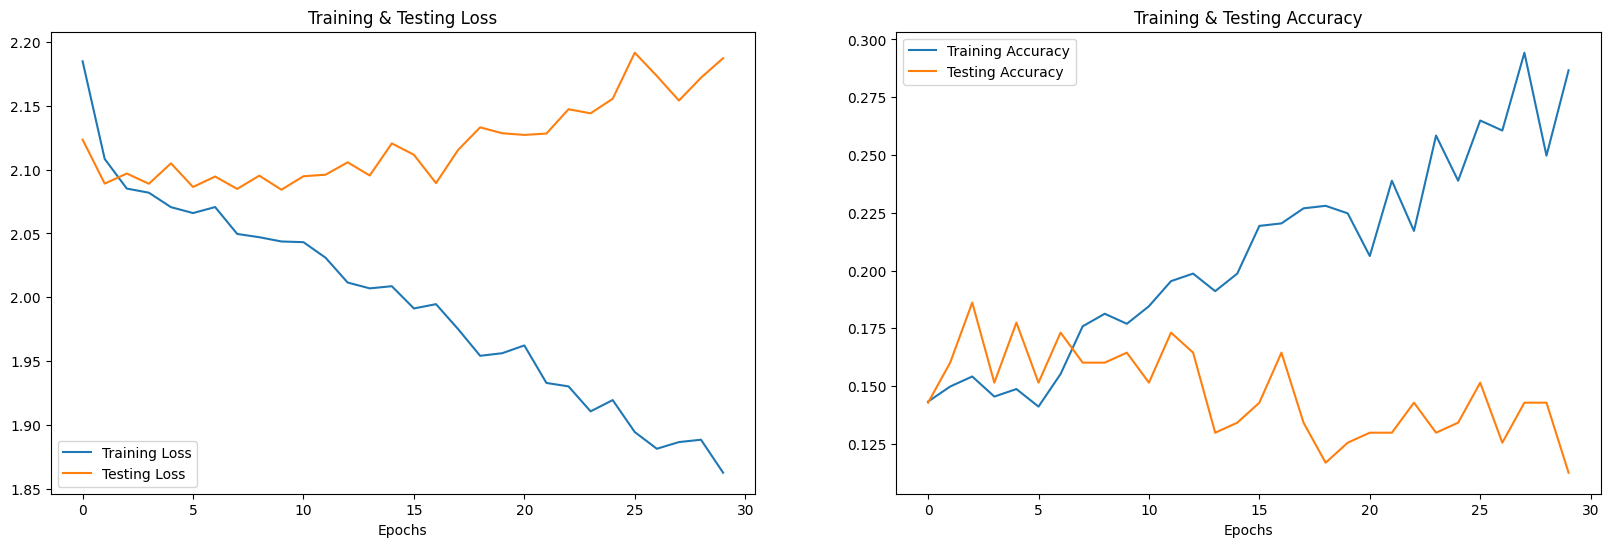

In [81]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()